In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary

**DISCLAIMER**

The presented code is not optimized, it serves an educational purpose. It is written for CPU, it uses only fully-connected networks and an extremely simplistic dataset. However, it contains all components that can help to understand how an autoregressive model (ARM) works, and it should be rather easy to extend it to more sophisticated models. This code could be run almost on any laptop/PC, and it takes a couple of minutes top to get the result.

### Dataset

In this example, we go wild and use a dataset that is simpler than MNIST! We use a scipy dataset called Digits. It consists of ~1500 images of size 8x8, and each pixel can take values in $\{0, 1, \ldots, 16\}$.

The goal of using this dataset is that everyone can run it on a laptop, without any gpu etc.

DigitsDataset --> 
	 dataset.shape: (1797, 64) 
	 index0.shape: (64,)


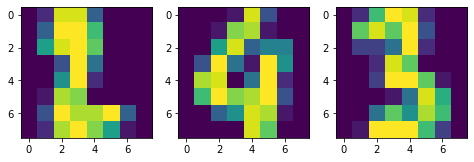

In [2]:
# Take a look at the Digits Dataset for intuition
digitsDataset = load_digits().data
print(f'DigitsDataset --> \n\t dataset.shape: {digitsDataset.shape} \n\t \
index0.shape: {digitsDataset[0].shape}')
# Note that there are no labels but only image pixels present in our data

# visualize some of the inputs
num = 3
fig = plt.figure(figsize=(8,10))
    
for i in range(num):
    rand_index = np.random.randint(0, digitsDataset.shape[0])
    fig.add_subplot(1, num, i+1)
    plt.imshow(digitsDataset[rand_index].reshape(8,8))

In [3]:
# Create a Pytorch custom Dataset ("Digits"). 
# To do so: [Extend the "Dataset" Class, implement __len__() and __getitem__() functions]
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

### ARM code

Please see the blogpost for details.

In [4]:
# Create a class to be used in our Causal Conv1d implementations in the Autoregressive Model(ARM)
class CausalConv1d(nn.Module):
    """
    A causal 1D convolution.
    """
# Note: "A" means that the input at time t is not fed into(i.e. masked) the model (causal).
    def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs):
        super(CausalConv1d, self).__init__()

        # attributes:
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A # flag that indicates whether current time step input will be fed into the model as input
        
        self.padding = (kernel_size - 1) * dilation + A * 1 
        # Note that "padding" is required since for the first convolution operation given a sequence x, we will
        # need to have F-1 many entries to multiply with the kernel to produce the output for the time step= 0.
        # Since we do not have input values for the sequence at any time step earlier than t=0, we pad only the 
        # left side of the sequence x, so that the kernel can have enough inputs to convolve at time step t=0 
        # to produce the output of the first(t=0) convolution operation. Also, note that no padding on the right
        # is applied since kernel convolves to right starting form the left side. 

        # module:
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride=1,
                                      padding=0,
                                      dilation=dilation,
                                      **kwargs)

    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0)) # Pad the left of the sequnce so that conv for t={0,...,F-1} can match size
        conv1d_out = self.conv1d(x)
        if self.A:
            return conv1d_out[:, :, : -1] # for causality purposes ignore the most recent time step output
        else:
            return conv1d_out

In [5]:
EPS = 1.e-5

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes) # Convert gt pixel values to one_hot for masking LL's
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS)) # Calculates Log Likelihood(LL) for the predicted pixel values
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [6]:
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        super(ARM, self).__init__()

        print('ARM by JT.')

        self.net = net
        self.num_vals = num_vals # number of possible pixel values (i.e. output layer dimension)
        self.D = D # Image Dimension (sqrt(D) by sqrt(D) image)

    def f(self, x): # computes forward pass and returns softmax probs.
        h = self.net(x.unsqueeze(1)) # Extend dimensions of the input for batch processing

        h = h.permute(0, 2, 1) # final_shape = (1, len(x), num_vals)
        p = torch.softmax(h, 2) # calculate pred probs of pixel values for each pixel location
        return p
        
    def forward(self, x, reduction='avg'):
        if reduction == 'avg':
            return -(self.log_prob(x).mean()) # multiply by -1 to have Negative Log Likelihood (NLL)
        elif reduction == 'sum':
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either `avg` or `sum`.')

    def log_prob(self, x): # returns Log Likelihood (LL)
        mu_d = self.f(x)
        log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
        
        return log_p

    def sample(self, batch_size):
        x_new = torch.zeros((batch_size, self.D))

        for d in range(self.D): # sample new image pixel by pixel
            p = self.f(x_new)
            x_new_d = torch.multinomial(p[:, d, :], num_samples=1) # sample pixel value wrt softmax weights for every batch
            x_new[:, d] = x_new_d[:,0]

        return x_new

### Auxiliary functions: training, evaluation, plotting

It's rather self-explanatory, isn't it?

In [7]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval() # turn on the evaluation mode of the pytorch model
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [8]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = [] # negative log likelihood loss history for validations
    best_nll = 1000.
    patience = 0 # keeps track of number of consecutive non improvements in the calculated loss(for early stopping)

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train() # put model into training mode (e.g. turns on layers such as dropout if present)
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch) # forward pass the input data

            optimizer.zero_grad()
            loss.backward(retain_graph=True) # compute gradients
            optimizer.step() # apply parameter updates

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:# early stopping
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Initialize dataloaders

In [10]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'arm'

### Hyperparams

In [11]:
D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

### Initialize ARM

In [16]:
likelihood_type = 'categorical'

num_vals = 17 # number of discrete values that each pixel can have

kernel = 7 # Filter/Kernel size

# Neural Network that will be used to learn a parameterized function of the probability distributaion of data
net = nn.Sequential( 
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False, bias=True))

model = ARM(net, D=D, num_vals=num_vals)

# Print the summary (like in Keras)
print(summary(model, torch.zeros(1, 64), show_input=False, show_hierarchical=False))

ARM by JT.
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
    CausalConv1d-1        [1, 256, 64]           2,048           2,048
       LeakyReLU-2        [1, 256, 64]               0               0
    CausalConv1d-3        [1, 256, 64]         459,008         459,008
       LeakyReLU-4        [1, 256, 64]               0               0
    CausalConv1d-5        [1, 256, 64]         459,008         459,008
       LeakyReLU-6        [1, 256, 64]               0               0
    CausalConv1d-7         [1, 17, 64]          30,481          30,481
Total params: 950,545
Trainable params: 950,545
Non-trainable params: 0
-----------------------------------------------------------------------


### Let's play! Training

In [19]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [20]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=118.40444893973215
saved!
Epoch: 1, val nll=112.05866001674107
saved!
Epoch: 2, val nll=109.60898088727679
saved!
Epoch: 3, val nll=107.97957868303571
saved!
Epoch: 4, val nll=105.75233258928571
saved!
Epoch: 5, val nll=103.51088936941964
saved!
Epoch: 6, val nll=101.12944196428572
saved!
Epoch: 7, val nll=98.84278738839286
saved!
Epoch: 8, val nll=97.16267926897322
saved!
Epoch: 9, val nll=95.62146135602678
saved!
Epoch: 10, val nll=95.0568017578125
saved!
Epoch: 11, val nll=93.85328404017856
saved!
Epoch: 12, val nll=93.33431919642857
saved!
Epoch: 13, val nll=93.42415597098214
Epoch: 14, val nll=92.62612444196428
saved!
Epoch: 15, val nll=92.30178850446428
saved!
Epoch: 16, val nll=91.67514718191964
saved!
Epoch: 17, val nll=92.06510811941965
Epoch: 18, val nll=91.40755022321429
saved!
Epoch: 19, val nll=91.23511300223214
saved!
Epoch: 20, val nll=91.21022321428572
saved!
Epoch: 21, val nll=90.66482979910714
saved!
Epoch: 22, val nll=90.50875
saved!
Epoch: 23, val 

In [21]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

FINAL LOSS: nll=86.46001337038591
